## Live Coding Demo


basierend auf dem MML-Buch von Marc Deisenroth und Yicheng Luo
https://mml-book.com


1. Code schreiben, der PCA implementiert.
2. Code schreiben, der die PCA für hochdimensionale Datensätze implementiert

In [56]:
import numpy as np
import timeit
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from ipywidgets import interact
from sklearn.datasets import load_digits

In [66]:
%matplotlib inline

In [67]:
digits = load_digits(n_class=10)
X, y = digits.data, digits.target
images, labels = digits.data, digits.target

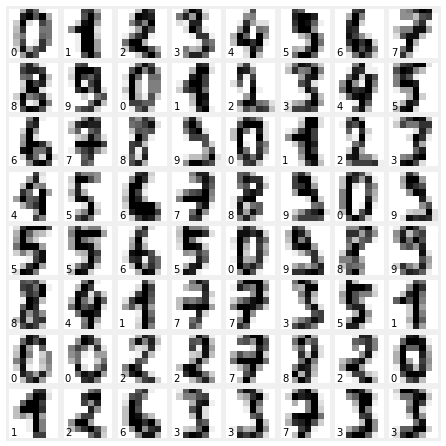

In [68]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

/tmp/ipykernel_22557/904827324.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


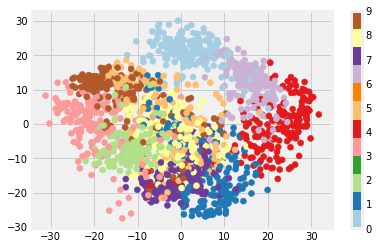

In [69]:
plt.figure()
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj = pca.fit_transform(digits.data)
plt.scatter(proj[:, 0], proj[:, 1], c=digits.target, cmap="Paired")
plt.colorbar()


Now, let's plot a digit from the dataset:

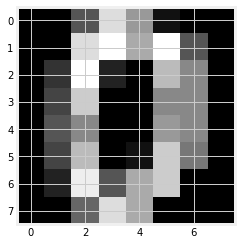

In [70]:
plt.figure(figsize=(4,4))
plt.imshow(images[0].reshape(8,8), cmap='gray');

## 1. Grundlegende PCA

Jetzt werden wir PCA implementieren. Bevor wir das tun, sollten wir einen Moment innehalten und
über die Schritte zur Durchführung der PCA nachdenken. Angenommen, wir führen eine PCA für
einem Datensatz $\boldsymbol X$ für $M$ Hauptkomponenten durchführen.
Dann müssen wir die folgenden Schritte durchführen, die wir in Teile unterteilen:


1. die Normalisierung und Standardisierung der Daten(` normalisieren`)
2. die Eigenwerte und die entsprechenden Eigenvektoren für die Kovarianzmatrix $S$ finden.
Sortieren Sie nach den größten Eigenwerten und den zugehörigen Eigenvektoren(`eig`)
3. Anschließend können wir die Projektion und Rekonstruktion der Daten auf den von den obersten $n$-Eigenvektoren aufgespannten Raum berechnen.

In [41]:
def normalize(X):
    """Normalisierung des gegebenen Datensatzes X
        
    Args:
        X: ndarray, Datensatz
    
    Returns:
        (Xbar, mean, std): Tupel von ndarray, Xbar ist der normalisierte Datensatz
        mit Mittelwert 0 und Standardabweichung 1; mean und std sind der
        Mittelwert bzw. die Standardabweichung.
    
    Note:
        Sie werden auf Dimensionen stoßen, bei denen die Standardabweichung
        Null ist, für die bei einer Normalisierung die normalisierten Daten
        NaN sein. Behandeln Sie dies, indem Sie `std = 1` für diese
        Dimensionen bei der Normalisierung.
    """
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar, mu, std

def eig(S):
    """Berechnen Sie die Eigenwerte und die entsprechenden Eigenvektoren für 
        die Kovarianzmatrix S.
        
    Args:
        S: nDarray, Kovarianzmatrix
    
    Returns:
        (eigvals, eigvecs): ndarray, die Eigenwerte und Eigenvektoren

    Note:
        Die Eigenwerte und Eigenvektoren sollten in absteigender
        Reihenfolge der Eigenwerte
    """
    eigvals, eigvecs = np.linalg.eig(S)
    k = np.argsort(eigvals)[::-1]
    return eigvals[k], eigvecs[:,k]

def projection_matrix(B):
    """Berechnen Sie die Projektionsmatrix auf den von "B" aufgespannten Raum
    
    Args:
        B: nDarray der Dimension (D, M), die Basis für den Unterraum
    
    Returns:
        P: die Projektionsmatrix
    """
    return (B @ np.linalg.inv(B.T @ B) @ B.T)

def PCA(X, num_components):
    """
    Args:
        X: nDarray der Größe (N, D), wobei D die Dimension der Daten ist,
            und N die Anzahl der Datenpunkte ist
       num_components: die Anzahl der zu verwendenden Hauptkomponenten.
    Returns:
        X_reconstruct: ndarray der Rekonstruktion
        von X aus den ersten `num_components` Hauptkomponenten.
    """
    # zunächst werden die Ziffern normalisiert, so dass sie einen Mittelwert 
    # von Null und eine Einheitsvarianz haben.
    
    # berechnen Sie dann die Kovarianzmatrix S der Daten
    S = 1.0/len(X) * np.dot(X.T, X)

    # als nächstes werden die Eigenwerte und die entsprechenden Eigenvektoren für S
    eig_vals, eig_vecs = eig(S)

    # Indizes für die größten Eigenwerte zu finden, sie zum Sortieren der Eigenwerte 
    # zu verwenden und entsprechende Eigenvektoren.
    eig_vals, eig_vecs = eig_vals[:num_components], eig_vecs[:, :num_components]

    # Dimensionalitätsreduktion der Originaldaten
    B = np.real(eig_vecs)
    
    # Z = X.T.dot(W)
    # die Bilder aus der niederdimensionalen Darstellung rekonstruieren
    reconst = (projection_matrix(B) @ X.T)
    return reconst.T


In [42]:
## Einige Vorverarbeitungen der Daten
NUM_DATAPOINTS = 1000
X = (images.reshape(-1, 8 * 8)[:NUM_DATAPOINTS]) / 255.
Xbar, mu, std = normalize(X)

In [43]:
for num_component in range(1, 20):
    from sklearn.decomposition import PCA as SKPCA
    # Wir können eine Standardlösung berechnen, die von der 
    # PCA-Implementierung von scikit-learn vorgegeben wird
    pca = SKPCA(n_components=num_component, svd_solver='full')
    sklearn_reconst = pca.inverse_transform(pca.fit_transform(Xbar))
    reconst = PCA(Xbar, num_component)
    np.testing.assert_almost_equal(reconst, sklearn_reconst)
    print(np.square(reconst - sklearn_reconst).sum())

1.785495308190812e-24
2.5188917860217492e-24
1.807977923466343e-24
1.8215173589163017e-24
2.472614880058604e-24
2.7486354216471514e-24
2.246325799377376e-24
1.9619092154525834e-24
2.0160754506859972e-24
3.551603663890549e-24
1.8232159045821367e-24
2.1426654574812744e-24
5.127343514601955e-23
1.4600304119684607e-24
2.4805561877601263e-24
4.563986649385044e-23
1.8608068531706224e-23
9.746519515538445e-24
3.179329560565787e-24


In [44]:
def mse(predict, actual):
    """Helper function for computing the mean squared error (MSE)"""
    return np.square(predict - actual).sum(axis=1).mean()

In [45]:
loss = []
reconstructions = []

# Iteration über verschiedene Anzahlen von Hauptkomponenten und Berechnung des MSE
for num_component in range(1, 100):
    reconst = PCA(Xbar, num_component)
    error = mse(reconst, Xbar)
    reconstructions.append(reconst)
    # print('n = {:d}, reconstruction_error = {:f}'.format(num_component, error))
    loss.append((num_component, error))

reconstructions = np.asarray(reconstructions)
reconstructions = reconstructions * std + mu # "unnormalize" the reconstructed image
loss = np.asarray(loss)

In [46]:
import pandas as pd
# Erstellen einer Tabelle mit der Anzahl der Hauptkomponenten und dem MSE
pd.DataFrame(loss).head()

,0,1
0,1.0,53.608534
1,2.0,47.675988
2,3.0,42.595492
3,4.0,38.251548
4,5.0,35.029516


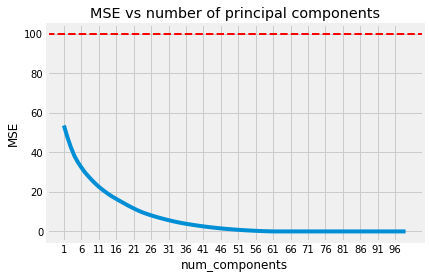

In [47]:
fig, ax = plt.subplots()
ax.plot(loss[:,0], loss[:,1]);
ax.axhline(100, linestyle='--', color='r', linewidth=2)
ax.xaxis.set_ticks(np.arange(1, 100, 5));
ax.set(xlabel='num_components', ylabel='MSE', title='MSE vs number of principal components');

## 2. PCA für hochdimensionale Datensätze

Manchmal kann die Dimensionalität unseres Datensatzes größer sein als die Anzahl der Stichproben, die wir haben. Dann könnte es ineffizient sein, PCA mit unserer obigen Implementierung durchzuführen. Stattdessen, können wir die PCA auf eine effizientere Weise implementieren, die wir "PCA für hochdimensionale Daten" (PCA_high_dim) nennen.

Nachfolgend sind die Schritte zur Durchführung von PCA für hochdimensionale Datensätze aufgeführt
1. Berechnen Sie die Matrix $\boldsymbol X\boldsymbol X^T$ (eine $N$ mal $N$ Matrix mit $N \ll D$)
2. Berechnen Sie Eigenwerte $\lambda$s und Eigenvektoren $V$ für $\boldsymbol X\boldsymbol X^T$
3) Berechnen Sie die Eigenvektoren der ursprünglichen Kovarianzmatrix als $\boldsymbol X^T\boldsymbol V$. Wählen Sie die Eigenvektoren, die mit den M größten Eigenwerten assoziiert sind, als Basis für den Hauptunterraum $U$.
4) Berechnen Sie die orthogonale Projektion der Daten auf den Unterraum, der von den Spalten von $\boldsymbol U$ aufgespannt wird.

In [71]:
### PCA für hochdimensionale Datensätze

def PCA_high_dim(X, n_components):
    """Berechnen Sie PCA für kleine Stichprobengrößen, aber hochdimensionale Merkmale. 
    Args:
        X: nDarray der Größe (N, D), wobei D die Dimension der Stichprobe ist,
            und N die Anzahl der Stichproben ist
        num_components: die Anzahl der zu verwendenden Hauptkomponenten.
    Returns:
        X_reconstruct: (N, D) ndarray. die Rekonstruktion
            von X aus den ersten `num_components`-Prinzipalkomponenten.
    """
    N, D = X.shape
    M = np.dot(X, X.T) / N
    eig_vals, eig_vecs = eig(M)
    eig_vals, eig_vecs = eig_vals[:n_components], eig_vecs[:, :n_components]
    U = (X.T @ (eig_vecs))
    answer = np.zeros((N, D))
    answer = ((U @ np.linalg.inv(U.T @ U) @ U.T) @ X.T).T
    return answer